In [2]:
import numpy as np
import pandas as pd
import torch
from sc_sharp import scSHARP
from test_model import test_model
import utilities
import matplotlib.pyplot as plt
import seaborn as sns

/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
grid_results = pd.read_csv("grid_search_pbmc_output/combined.csv", header=None, index_col=0)
grid_results.columns = ["Total Accuracy", "Val Accuracy", "Test Accuracy", "Total SD", "Val SD", "Test SD", "Config", "Dropout", "Batch", "Neighbors"]
grid_results['GCN Layers'] = grid_results['Config'].apply(lambda x: x.split('_')[0])
grid_results['Final Embedding'] = grid_results['Config'].apply(lambda x: x.split('_')[1].split(".")[0])
grid_results['GCN Layers'] = pd.to_numeric(grid_results['GCN Layers'])
grid_results['Final Embedding'] = pd.to_numeric(grid_results['Final Embedding'])
grid_results.sort_values("Val Accuracy", ascending=False).head(10)

,Total Accuracy,Val Accuracy,Test Accuracy,Total SD,Val SD,Test SD,Config,Dropout,Batch,Neighbors,GCN Layers,Final Embedding
0,,,,,,,,,,,,
98,0.959807,0.941689,0.0,0.000524,0.002700,0.0,2_40.txt,0.0,50,5,2,40
16,0.959729,0.941287,0.0,0.001116,0.005750,0.0,2_25.txt,0.0,95,2,2,25
4,0.959625,0.940751,0.0,0.000812,0.004182,0.0,2_25.txt,0.0,35,2,2,25
161,0.959625,0.940751,0.0,0.000793,0.004085,0.0,2_60.txt,0.0,95,5,2,60
154,0.959443,0.939812,0.0,0.001093,0.005633,0.0,2_60.txt,0.0,65,2,2,60
157,0.959157,0.939812,0.0,0.001011,0.002230,0.0,2_60.txt,0.0,80,2,2,60
107,0.959339,0.939276,0.0,0.000736,0.003794,0.0,2_40.txt,0.0,95,5,2,40
139,0.959079,0.939142,0.0,0.000859,0.002543,0.0,2_15.txt,0.0,80,2,2,15
160,0.959287,0.939008,0.0,0.000565,0.002913,0.0,2_60.txt,0.0,95,2,2,60


<AxesSubplot:xlabel='Final Embedding', ylabel='Val Accuracy'>

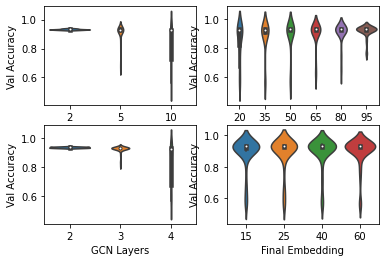

In [5]:
fig, axs = plt.subplots(2,2)
sns.violinplot(x=grid_results["Neighbors"], y=grid_results["Val Accuracy"], ax = axs[0][0])
sns.violinplot(x=grid_results["Batch"], y=grid_results["Val Accuracy"], ax = axs[0][1])
sns.violinplot(x=grid_results["GCN Layers"], y=grid_results["Val Accuracy"], ax = axs[1][0])
sns.violinplot(x=grid_results["Final Embedding"], y=grid_results["Val Accuracy"], ax = axs[1][1])

accuracy results generated this way:

srun --partition=gpu --mem=130g --time=500 python -u test_model.py
data_folders = ["/home/groups/ConradLab/daniel/sharp_data/pbmc_test/"]
    tools = ["sctype","scsorter","scina", "singler", "scpred"]
    votes_necessary = .51
    model_file = "configs/2_40.txt"
    neighbors = 5
    batch_size=50
    training_epochs=150
    random_inits = 5
    counts="counts.csv"
    meta="labels_cd4-8.csv"
    meta_col = 0
    df = test_model(data_folders, tools, votes_necessary, model_file, neighbors, batch_size, training_epochs, random_inits, counts=counts, meta=meta, meta_col=meta_col)
    df.to_csv("pbmc_test_results.csv")


In [6]:
results = pd.read_csv("pbmc_test_results.csv", index_col=0)
results

,data_name,method,total_accuracy,train_accuracy,test_accuracy,total_sd,train_sd,test_sd
0,pbmc_test,GCN,0.930186,0.937344,0.681247,0.000749,0.000207,0.019805
1,pbmc_test,Max Col.,0.921346,0.937523,0.358772,0.000000,0.000000,0.000000
2,pbmc_test,Confident Labels,NaN,0.937523,NaN,0.000000,0.000000,0.000000
3,pbmc_test,sctype,0.971137,0.973760,0.879944,0.000000,0.000000,0.000000
4,pbmc_test,scsorter,0.714819,0.716012,0.673336,0.000000,0.000000,0.000000
5,pbmc_test,scina,0.733328,0.753519,0.031177,0.000000,0.000000,0.000000
6,pbmc_test,singler,0.702813,0.719959,0.106561,0.000000,0.000000,0.000000
7,pbmc_test,scpred,0.744176,0.761535,0.140530,0.000000,0.000000,0.000000
8,pbmc_test,Tool Avg.,0.773255,0.784957,0.366310,0.111774,0.107426,0.383681


Text(0.5, 1.0, 'Total Accuracy by Method')

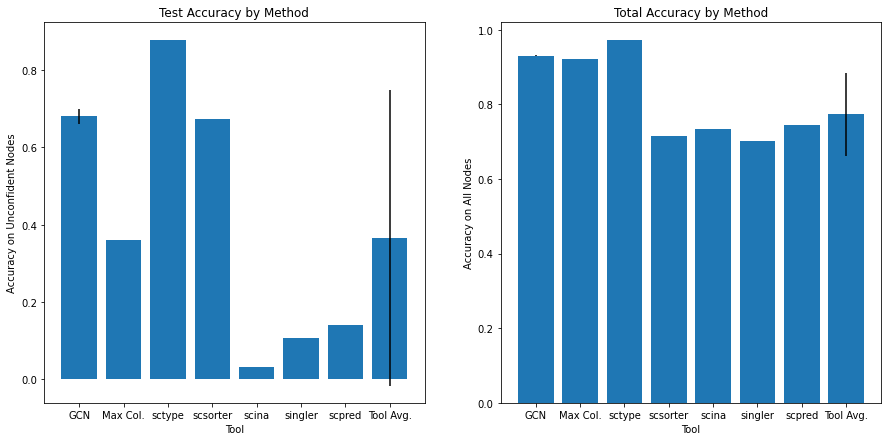

In [7]:
to_plot = results.loc[results['method']!="Confident Labels",:]
fig, ax = plt.subplots(1,2,figsize=(15, 7))
ax[0].bar(to_plot['method'],  to_plot['test_accuracy'], yerr= to_plot['test_sd'], align='center')
ax[0].set_xlabel("Tool")
ax[0].set_ylabel("Accuracy on Unconfident Nodes")
ax[0].set_title("Test Accuracy by Method")
ax[1].bar(to_plot['method'],  to_plot['total_accuracy'], yerr= to_plot['total_sd'], align='center')
ax[1].set_xlabel("Tool")
ax[1].set_ylabel("Accuracy on All Nodes")
ax[1].set_title("Total Accuracy by Method")

In [4]:
real_labels = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_test/labels_cd4-8.csv", index_col=0).iloc[:,0]
real_labels,keys = pd.factorize(real_labels, sort=True)
keys

Index(['b_cells', 'cd14_monocytes', 'cd4_t_cell', 'cd56_nk', 'cd8_t_cell'], dtype='object')

[Text(0.5, 14.09375, 'Cell Type')]

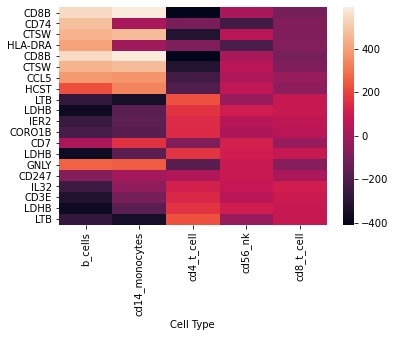

In [6]:
int_df = pd.read_csv("pbmc_test_interpretation.csv", index_col=0)
int_df.columns = keys

keep_genes = int_df.sort_values('b_cells', ascending=False).head(4).index.tolist()
keep_genes += int_df.sort_values('cd14_monocytes', ascending=False).head(4).index.tolist()
keep_genes += int_df.sort_values("cd4_t_cell", ascending=False).head(4).index.tolist()
keep_genes += int_df.sort_values("cd56_nk", ascending=False).head(4).index.tolist()
keep_genes += int_df.sort_values("cd8_t_cell", ascending=False).head(4).index.tolist()
ax = sns.heatmap(int_df.loc[keep_genes,:])
ax.set(xlabel="Cell Type")

In [17]:
int_df.sort_values("cd4_t_cell", ascending=False).head(15)

,b_cells,cd14_monocytes,cd4_t_cell,cd56_nk,cd8_t_cell
LTB,-271.98730,-348.988900,227.514130,-26.931700,80.667620
LDHB,-376.18976,-172.631620,163.972640,100.975820,83.362920
IER2,-256.89252,-164.240920,142.495500,42.580680,62.696600
CORO1B,-224.87576,-176.731500,140.287280,18.473130,51.965760
CD3E,-322.06000,-104.652180,135.357570,47.813282,87.723600
JUNB,-279.31616,-145.319300,134.117780,43.088936,67.027596
S100A4,-229.28241,-57.288850,129.590930,58.569954,74.968430
GAPDH,-216.52810,-111.923850,121.884080,40.314810,62.347084
GSTK1,-190.17888,-138.486530,117.940990,32.224606,59.531876
FTH1,-193.27945,-167.798280,117.332760,-25.634762,29.962380


In [21]:
int_df.sort_values("cd8_t_cell", ascending=False).loc["CD8A",:]

b_cells           254.549060
cd14_monocytes    268.200230
cd4_t_cell       -182.814470
cd56_nk             0.449513
cd8_t_cell        -43.660416
Name: CD8A, dtype: float64